# Still a divided city? Exploring AirBnB data in Berlin

Explorative data analysis of the Berlin AirBnB dataset from 31-Oct-2020


![Berlin](img/berlin.jpg)


## 1. Problem defintion

The purpose of this AirBnB Berlin dataset analysis is to address the following questions:
1. What are the major determents for the price?
2. Where are the most expensive neighbourhoods?
3. Where are the most frequently visited neighbourhoods?
4. How does the reviews change over time?


## 2. Data

The analyzed data set was downloaded directly from the [AirBnB webpage](http://insideairbnb.com/get-the-data.html).
Specifically, files were used for this analysis:

**Files:**
* `listings.csv`	Summary information and metrics for listings in Berlin.
* `reviews.csv.gz`	Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).
* `neighbourhoods.csv`	Neighbourhood list for geo filter. Sourced from city or open source GIS files.
* `neighbourhoods.geojson`	GeoJSON file of neighbourhoods of the city.

## 3. Data preperation

**Import Packages and load data**

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import Counter
from scipy.stats import zscore
#import contextily as ctx
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from wordcloud import WordCloud
from tqdm import tqdm

# set options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None  # default='warn
sns.set(font_scale=1.2)
sns.set_theme(style="white")

In [2]:
# import listings and review data
df_full = pd.read_csv('./data/listings.csv.gz')
rev_full = pd.read_csv('./data/reviews.csv.gz')

print(df_full.shape)
df_full.head().T

(20227, 74)


,0,1,2,3,4
id,2015,3176,3309,7071,9991
listing_url,https://www.airbnb.com/rooms/2015,https://www.airbnb.com/rooms/3176,https://www.airbnb.com/rooms/3309,https://www.airbnb.com/rooms/7071,https://www.airbnb.com/rooms/9991
scrape_id,20201013162227,20201013162227,20201013162227,20201013162227,20201013162227
last_scraped,2020-10-21,2020-10-20,2020-10-21,2020-10-19,2020-10-20
name,Berlin-Mitte Value! Quiet courtyard/very central,Fabulous Flat in great Location,BerlinSpot Schöneberg near KaDeWe,BrightRoom with sunny greenview!,Geourgeous flat - outstanding views
description,Great location! <br />30 of 75 sq meters. Thi...,This beautiful first floor apartment is situa...,First of all:<br />I prefer short-notice booki...,Cozy and large room in the beautiful district ...,4 bedroom with very large windows and outstand...
neighborhood_overview,It is located in the former East Berlin area o...,The neighbourhood is famous for its variety of...,"My flat is in the middle of West-Berlin, direc...","Great neighborhood with plenty of Cafés, Baker...",Prenzlauer Berg is an amazing neighbourhood wh...
picture_url,https://a0.muscache.com/pictures/260fd609-710a...,https://a0.muscache.com/pictures/243355/84afcf...,https://a0.muscache.com/pictures/29054294/b1fa...,https://a0.muscache.com/pictures/21278/32a1622...,https://a0.muscache.com/pictures/42799131/59c8...
host_id,2217,3718,4108,17391,33852
host_url,https://www.airbnb.com/users/show/2217,https://www.airbnb.com/users/show/3718,https://www.airbnb.com/users/show/4108,https://www.airbnb.com/users/show/17391,https://www.airbnb.com/users/show/33852


**Data cleaning**

In [4]:
# columns of interest to keep for data analysis
col_to_keep = ['id', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
            'latitude', 'longitude','property_type','room_type',
            'accommodates', 'beds', 'amenities', 'price', 'number_of_reviews',
            'first_review','last_review', 'reviews_per_month', 'availability_365',
            'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [5]:
# transform functions:

def clean_data(df):
    """
    Transform columns to appriate dtypes and handle int missing values
    """
    
    # convert price column to numeric
    if not pd.api.types.is_numeric_dtype(df['price']):
        df.loc[:,'price'] = df.loc[:,'price'].str.replace('[$,]','').astype('float')
    
    # transform columns to int
    to_int = ['accommodates','beds','number_of_reviews']
    df.loc[:,to_int] = df.loc[:,to_int].apply(lambda x: x.fillna(x.median(), axis=0)) 
    df.loc[:,to_int] = df.loc[:,to_int].astype('int')
        
    # transform columns to categorical
    to_cat = ['neighbourhood_cleansed','neighbourhood_group_cleansed',
              'property_type','room_type']
    df.loc[:,to_cat] = df.loc[:,to_cat].astype('category')

    
    # transfrom columns to datetimes
    to_dt = ['first_review','last_review']
    df.loc[:,to_dt] = df.loc[:,to_dt].apply(pd.to_datetime)
    
    return df    


def check_is_west_berlin(df):
    """
    Check if the listing is located in the former west of Berlin.
    """
    
    # read shape file with the former west-berlin area and transform it as a polygon
    west_berlin_shp = gpd.read_file('./data/berlin-wall.geojson')
    west_berlin_poly = Polygon(west_berlin_shp.loc[0, 'geometry'])
    
    # check if the listing's longitude and latiude is within the west-berlin polygion
    df.loc[:,'is_west'] = [Point(row.longitude, row.latitude).within(west_berlin_poly) 
                           for row in df.itertuples()]

    return df


def expand_amenities(df, min_entries = 10):
    """
    Exand the amenities-list and create boolean columns for the most common entries
    """
    
    # create a Counter-dict to count the occurence of all amenity entries
    all_amenities = [item for row in df.amenities for item in eval(row)]
    ctr_amenities = Counter(all_amenities)
    
    # filter the amenities according to min_entries
    common_amenities = {key for key, value in ctr_amenities.items() if value > min_entries}

    # loop over amenities, check occurence and create boolean 
    for amenity in tqdm(common_amenities):
        df[f"has_{amenity.replace(' ','_')}"] = [amenity in eval(row) for row in df.amenities]

    # count the number all amenities
    df['amenities_count'] = df.loc[:,df.columns.str.contains('has_')].sum(axis=1)
    
    return df, all_amenities 


# transform dtypes
df = clean_data(df_full[col_to_keep])

# add boolean feature, if the neighbourhood is located in former west berlin
df = check_is_west_berlin(df)

# one-hot unpacking of the nested amenities items 
df, all_amenities = expand_amenities(df)
df.drop('amenities', axis=1, inplace=True)


# MISC
df['not_reviewed'] = df.first_review.isnull()    
df['review_time_year'] = (df.last_review.dt.year - df.first_review.dt.year)
df.drop(['first_review','last_review'], axis=1, inplace=True)


# handle outliers
MAX_PRICE = 800
MAX_BEDS = 20
MAX_BEDROOMS= 15
df = df.query('(1 < price <= @MAX_PRICE) & (beds <= @MAX_BEDS)')
    

#and add standardized price as feature    
df.loc[:,'price_std'] = zscore(df.loc[:,'price'])

# reviews per neighborhood
len_by_group = df.groupby('neighbourhood_group_cleansed').agg({'id':len}).reset_index()
len_by_group.columns = len_by_group.columns.str.replace('id','len_by_group')

len_by_dist = df.groupby('neighbourhood_cleansed').agg({'id':len}).reset_index()
len_by_dist.columns = len_by_dist.columns.str.replace('id','len_by_dist')

df = df.merge(len_by_group, on='neighbourhood_group_cleansed')
df = df.merge(len_by_dist, on='neighbourhood_cleansed')

# manual fix 
df = df.loc[~((df.neighbourhood_group_cleansed == "Steglitz - Zehlendorf") & (df.is_west == False)),:]
df = df.loc[~((df.neighbourhood_group_cleansed == "Spandau") & (df.is_west == False)),:]

bkp = df.copy() 

100%|██████████| 110/110 [00:54<00:00,  2.02it/s]


In [6]:
# add geo-spatial data and create GeoDataFrames

# read spatial polygons for each neighbourhoods
neighbours = gpd.read_file('./data/neighbourhoods.geojson')

# add polygons according to the listings
gdf_poly = gpd.GeoDataFrame(pd.merge(df, neighbours, 
                              left_on='neighbourhood_cleansed', 
                              right_on='neighbourhood'))

## 4. Data Analysis


**What determines the price of an listing?**

First, lets create a correlation matrix plot.

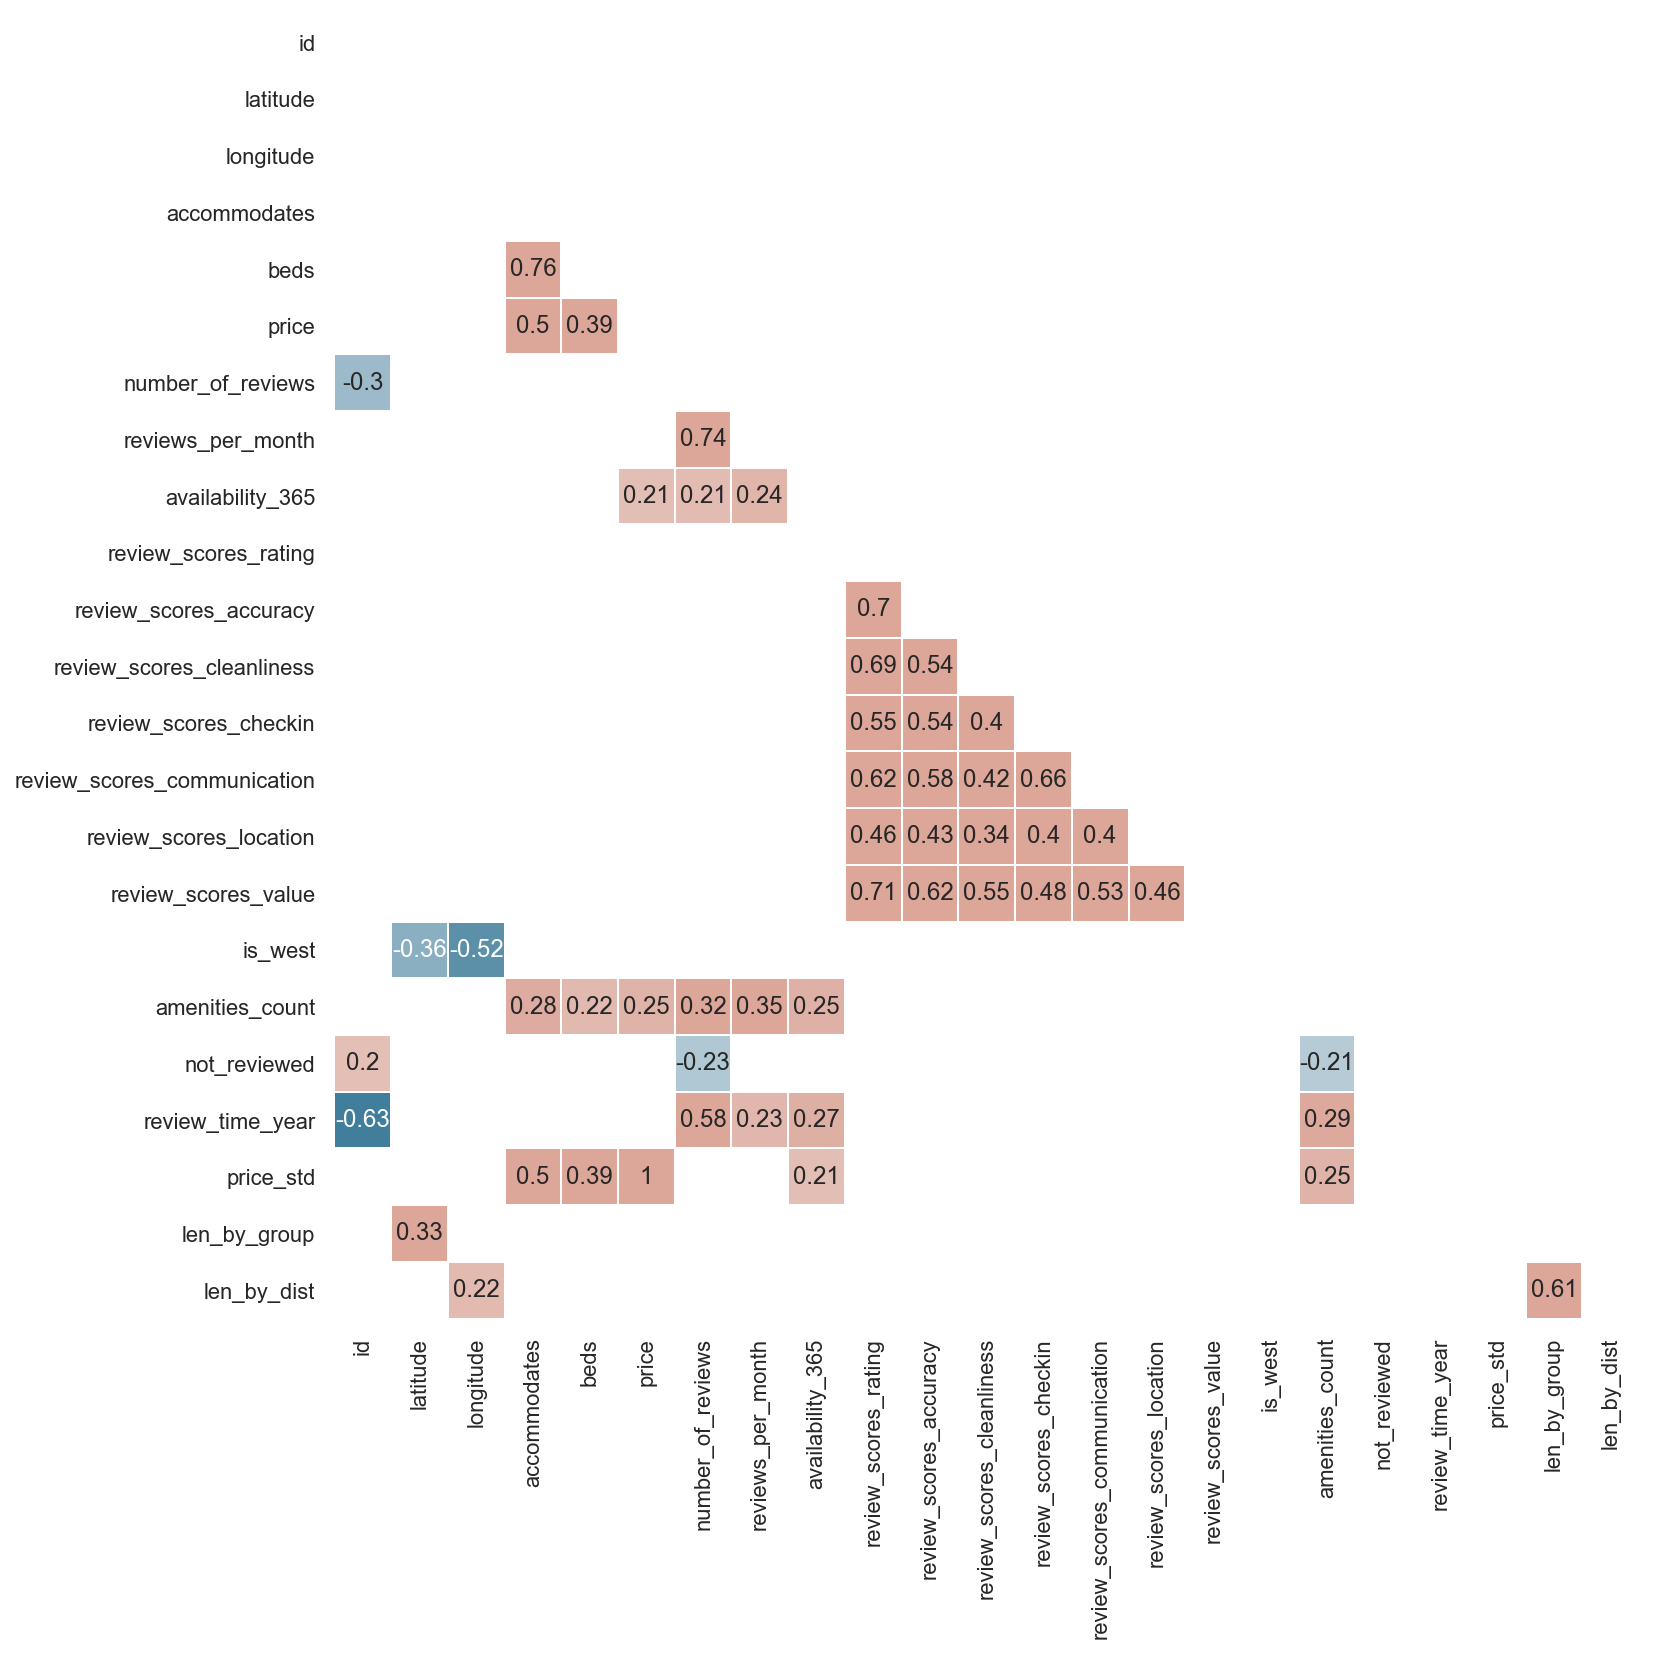

In [10]:
# Correlation analyis with numeric features and without amenities for visual purpose

# create corrlation matrix without amenities columns
cor_mat = df.iloc[:,~df.columns.str.contains('has')].corr()

# remove absolute correlation coefficients less than x
corr_threshold = .2
cor_mat[abs(cor_mat) <= corr_threshold] = np.nan

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_mat, dtype=bool))

fig, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_mat, cmap=cmap,  center=0, mask=mask, vmax=.3, annot=True,
            square=True, linewidths=.5, cbar=False)
plt.show()

Now, lets also consider the amenities.

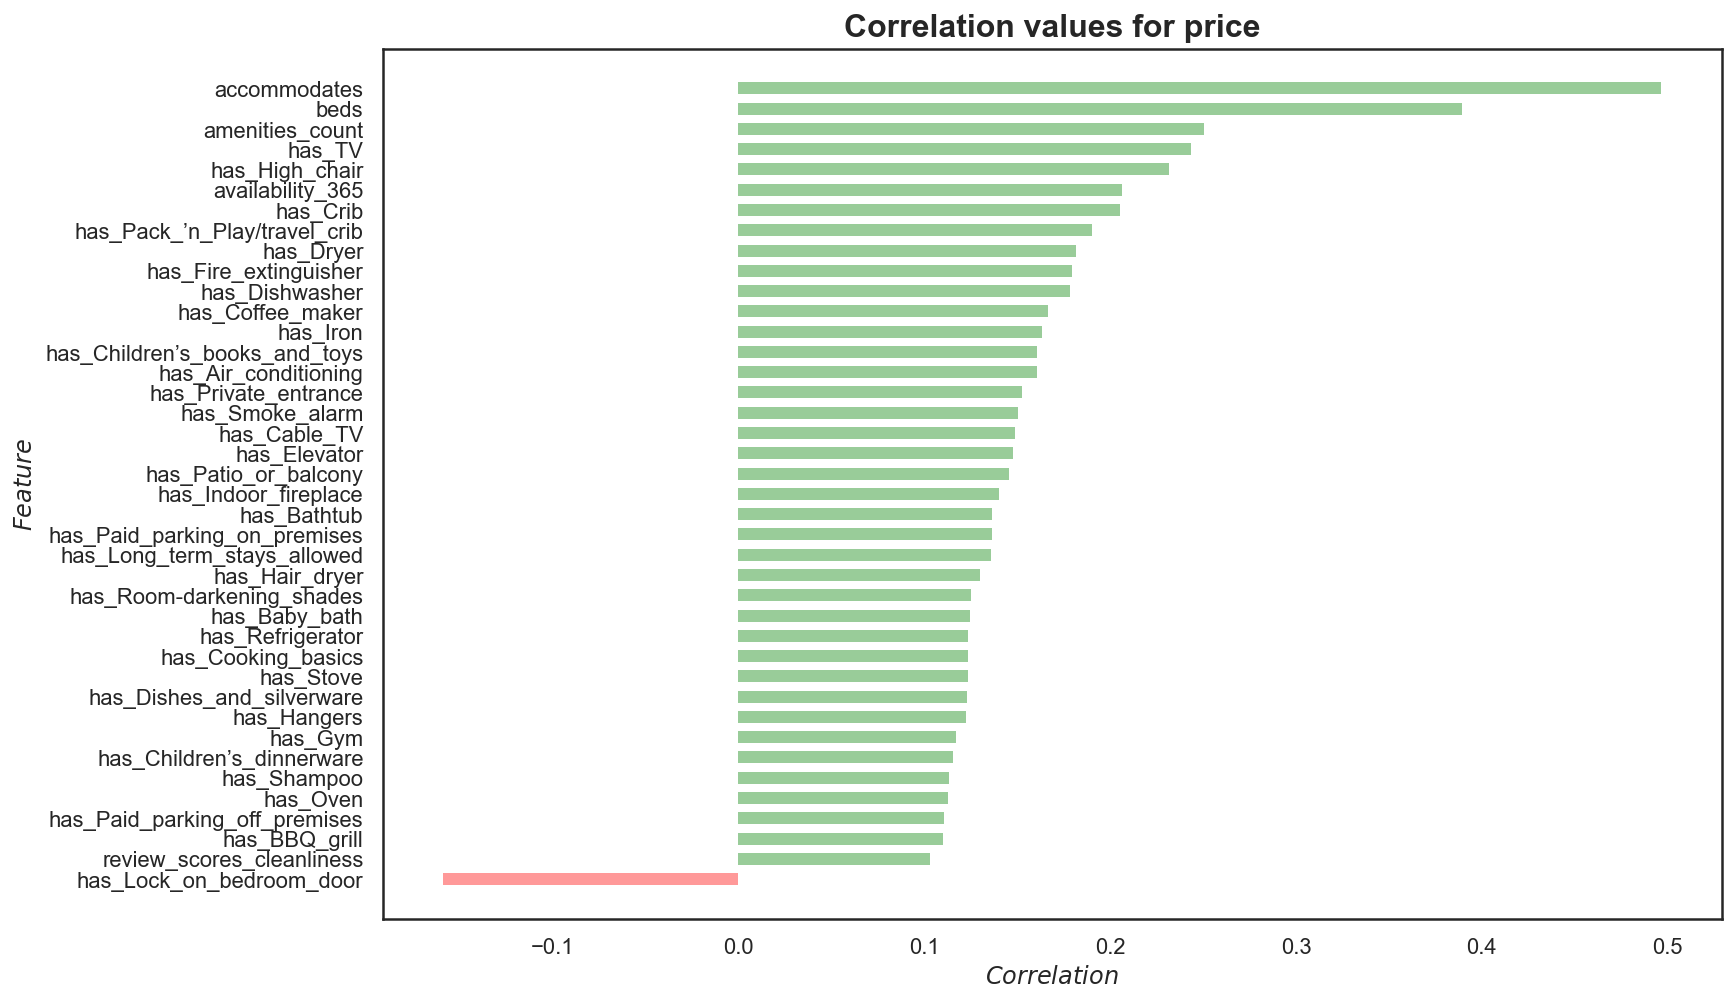

In [12]:
# Price specific analysis
def corr_bar_plot(df, var:str, ax, min_value=None, west_split=None):
    """
    Perform correlation analysis and plot r as horizontal bars.
    """
    
    # perform correlation and exctract variable
    corr_df = df.corr()
    corr_price = corr_df[[var]]
    
    corr_price.drop(var, axis=0, inplace=True)
    if var == 'price':
        corr_price.drop('price_std', axis=0, inplace=True)
    
    # ha
    corr_price['col'] = ['red' if price < 0 else 'green' for price in corr_price[var]]
    if min_value:        
        corr_price = corr_price.loc[abs(corr_price[var]) > min_value, :]
    corr_price.sort_values(var, inplace=True)
    corr_price.reset_index(inplace=True)
      
    # plot
    ax.hlines(y=corr_price.index, xmin=0, xmax=corr_price[var], color=corr_price.col, alpha=0.4, linewidth=6)

    # Decorations
    ax.set(ylabel='$Feature$',
           xlabel='$Correlation$')
    plt.yticks(corr_price.index, corr_price['index'])
    return ax


fig, ax = plt.subplots(figsize=(12,8))
ax = corr_bar_plot(df, 'price', ax=ax, min_value=.1)
ax.set_title(f'Correlation values for price', fontweight= 'bold', fontsize=16) 
plt.show()

**What are the most common amenities?**

In [ ]:
# create a wordcloud
wordcloud = WordCloud(max_font_size=120, max_words=None, 
                      width=960, height=480,
                      collocations=False, background_color="white").generate(' '.join(all_amenities))

# plot a wordcloud
fig, ax = plt.subplots(figsize=(16,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Types**

In [ ]:
# list the 10 most common amenities
pd.value_counts(all_amenities).nlargest(10)

In [ ]:
tmp = df.groupby(['room_type'])['price'].agg([np.nanmedian, len]).round(2).dropna().reset_index()
tmp.sort_values(by = 'nanmedian', inplace=True, ascending=False)
tmp

In [ ]:
tmp = df.groupby(['property_type'])['price'].agg([np.nanmedian, len]).round(2).dropna().reset_index()
tmp.sort_values(by = 'nanmedian', inplace=True, ascending=False)
tmp.query('len >=10')

**districts**

In [ ]:
dums = pd.get_dummies(df.neighbourhood_group_cleansed)
tmp = df[['price','price_std']].join(dums)

fig, ax= plt.subplots(figsize=(12,6))
corr_bar_plot(tmp, 'price', ax=ax)
plt.show()

### 3. Is Berlin still a divded city?

In [ ]:
# boxplot example
cols = ['price', 'accommodates' ,'beds','number_of_reviews', 'amenities_count']

In [ ]:
df.groupby(['is_west','neighbourhood_group_cleansed'])[cols].agg([np.nanmean, np.nanmedian]).round(2).dropna()

In [ ]:
df.query('(beds == 1.) & (accommodates == 2)').groupby(['is_west'])[cols].agg([np.nanmean, np.median]).round(2).dropna().T

In [ ]:
display(df.groupby(['accommodates','is_west']).agg({'price':np.nanmedian}).T)
display(df.groupby(['beds', 'is_west']).agg({'price':np.nanmedian}).T)

In [ ]:
a = df.groupby(['neighbourhood_group_cleansed','is_west'])[cols].agg(np.nanmedian).round(2).dropna()
a.sort_values(by = 'price', inplace=True, ascending=False)
a.head(15)

**Visual EDA**

In [ ]:
# Aggregte Data

# Plot spatially-aggregated data
def agg_and_plot(gdf, aggfun=np.median, level='neighbourhood', wall_path = './data/berlin_wall.json'):
    """
    Plot the berlin map with color-coded var column.
    """
    
    # aggreagte on level
    gdf = gdf_poly.dissolve(by=level, aggfunc=aggfun)
    
    # read berlin wall path
    berlin_wall = gpd.read_file(wall_path)
    
    # inner plot function which will be returned
    def inner_plot(var:str, ax, **kwargs):
        """
        Plot the gdf GeoDataFrame on axis with var color-coded
        """

        # plot data
        if kwargs is None: # use default
            gdf.plot(column = var, cmap='inferno', 
                     legend=True, ax=ax, alpha=.8, edgecolor='w', cax=cax);
        else: 
            gdf.plot(column = var, ax=ax, **kwargs);

        # add the berlin wall
        berlin_wall.plot(color='blue', linewidth=3, ax=ax)
        
        ax.set_axis_off()
        return ax
        
    return inner_plot

# create aggretated dataframe for visualization
plot_median = agg_and_plot(gdf_poly, aggfun=np.median)
plot_mean = agg_and_plot(gdf_poly, aggfun=np.mean)
plot_qt1 = agg_and_plot(gdf_poly, aggfun=lambda x: np.percentile(x, 25))
plot_qt2 = agg_and_plot(gdf_poly, aggfun=lambda x: np.percentile(x, 75))
plot_iqr = agg_and_plot(gdf_poly, aggfun=lambda x: np.subtract(*np.percentile(x, [75, 25])))


In [ ]:
# Plot the price
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(16,16), dpi=400)

v = 'len_by_dist'
ax0 = plot_median(v, ax0, cmap='YlOrRd',scheme='box_plot', legend=True) # natural_breaks
ax0.set_title('Number of reviews per listings', fontweight='bold')
#plot_iqr(v, ax1, cmap='YlOrRd',scheme='box_plot', legend=True)
#fig.suptitle('AirBnB Berlin', fontsize=40, fontweight='bold')
plt.show()

In [ ]:
# Plot the price
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(16,16), dpi=400)

v = 'price'
ax0 = plot_median(v, ax0, cmap='YlOrRd',scheme='quantiles', legend=True) # natural_breaks
ax0.set_title('Median price', fontweight='bold')
#plot_iqr(v, ax1, cmap='YlOrRd',scheme='box_plot', legend=True)
#fig.suptitle('AirBnB Berlin', fontsize=40, fontweight='bold')
plt.show()

In [ ]:
df['reviews_per_list'] = df['']

df.groupby(['neighbourhood_group_cleansed']).agg({'availability_365':np.nanmean, 
                                                  'number_of_reviews':np.nanmean}).dropna().sort_values('availability_365')

In [ ]:
# reviews_full
rev = pd.read_csv('./data/reviews.csv', parse_dates=['date'])
rev = rev.merge(df[['id','is_west']], left_on='listing_id', right_on='id')
rev.set_index('date', inplace=True)
rev.drop('listing_id', axis=1, inplace=True)
rev['review'] = 1




In [ ]:
rev.is_west.apply(lambda x: 1 if True else 0)

In [ ]:
# prepare data
spl = '7D'

rev_m = pd.DataFrame()
rev_m['reviews_mth'] = rev.review.resample(spl).sum()
rev_m['reviews_mth_west'] = rev.is_west.resample(spl).sum()
rev_m['reviews_mth_east'] = rev_m['reviews_mth'] - rev_m['reviews_mth_west']

rev_m = rev_m.truncate(before='2013')

# plot
fig, (ax0) = plt.subplots(nrows=1, figsize=(16,8), dpi=400)
ax0.plot(rev_m.index, rev_m.reviews_mth, c='grey', alpha=.4, label='Absolute')
ax0.plot(rev_m.index, rev_m.reviews_mth_west, c='r', alpha=.8, label='West Berlin')
ax0.plot(rev_m.index, rev_m.reviews_mth_east, c='b', alpha=.8, label='East Berlin')
plt.legend()
ax0.set_title('Reviews over Time in West- and East Berlin', fontweight='bold', fontsize=14)
ax0.set(xlabel='Year', ylabel='Freqeuncy of reviews')
plt.show()